In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import mahotas as mh

In [3]:
import cactas as C

In [4]:
# DATAPATH = '/home/d/Dropbox/RESEARCH/CAROTID/DATA/Nathan Arnett Calcification/'
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification/'

In [5]:
DATASETS = sorted([v for v in os.listdir(DATAPATH) if os.path.isdir(DATAPATH + v)])

images = []
labels = []

image_patches = []
label_patches = []

for i,d in enumerate(DATASETS):
    
    # ignore DICOM 12 since we have DICOM 12-checked
    if d == 'DICOM 12' or d == 'DICOM 61' or d == 'DICOM 51':
        continue
    

    image_with_header, label_with_header = C.Util.load(i, datapath=DATAPATH, with_header=True)

    spacing = [image_with_header[1]['space directions'][0,0],
               image_with_header[1]['space directions'][1,1],
               1]

    image = image_with_header[0]
    label = label_with_header[0]

    # normalize grayscale to 0..1
    image_normalized = C.Util.normalize(image)
    
    # remove empty slices
    image_filtered, label_filtered = C.Util.filter(image_normalized, label)

    # loop thru each slice
    for z in range(image_filtered.shape[2]):

        image_slice = image_filtered[:,:,z:z+1]
        label_slice = label_filtered[:,:,z:z+1]

        # relabel the segments
        relabel, obj = mh.label(label_slice)
        
#         print('relabeled')

        # loop thru each segment, binarize and crop
        for i in range(1, relabel.max()+1):

            single_label = np.zeros((relabel.shape), relabel.dtype)
            single_label[relabel == i] = 1

            image_cropped, single_label_cropped = C.Util.crop(image_slice, single_label, target_size=32)

            image_patches.append(image_cropped)
            label_patches.append(single_label_cropped)


    

    

In [6]:
maxX = 0
maxY = 0

for i,j in enumerate(image_patches):
    maxY = max(image_patches[i].shape[0], maxY)
    maxX = max(image_patches[i].shape[1], maxX)
    

In [7]:
maxY = 0
for i,img in enumerate(image_patches):
    
    if img.shape[0] > maxY: 
        print(i, img.shape[0])
        maxY = img.shape[0]

0 32
1 33


In [8]:
maxY, maxX

(33, 33)

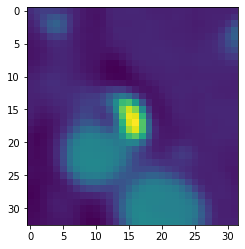

In [9]:
imshow(image_patches[731])

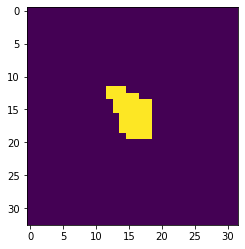

In [10]:
imshow(label_patches[731])

In [11]:
len(image_patches)

1034

/home/daniel.haehn/Projects/CACTAS/_EXPERIMENTS/cactas/util.py:146: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(slices,3))


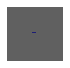

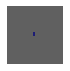

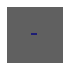

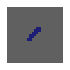

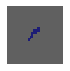

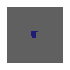

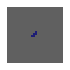

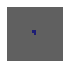

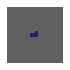

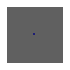

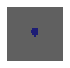

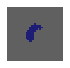

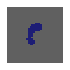

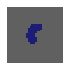

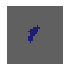

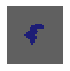

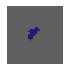

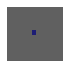

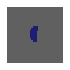

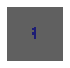

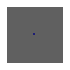

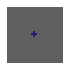

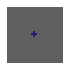

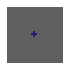

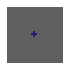

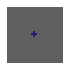

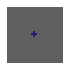

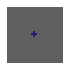

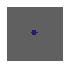

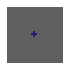

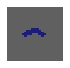

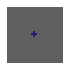

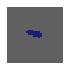

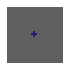

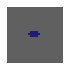

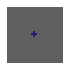

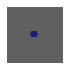

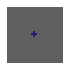

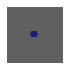

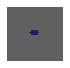

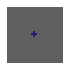

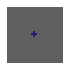

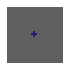

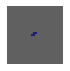

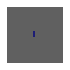

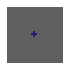

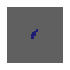

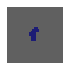

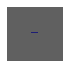

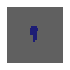

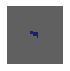

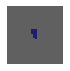

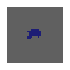

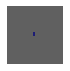

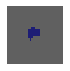

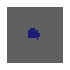

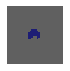

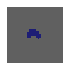

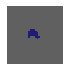

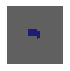

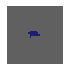

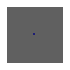

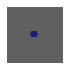

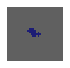

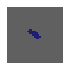

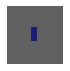

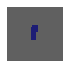

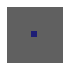

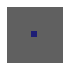

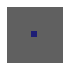

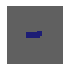

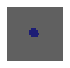

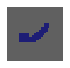

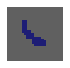

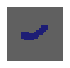

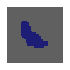

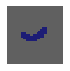

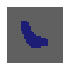

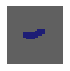

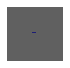

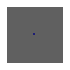

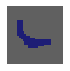

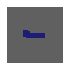

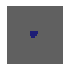

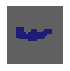

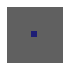

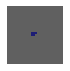

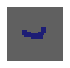

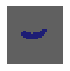

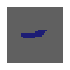

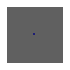

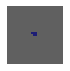

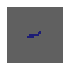

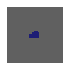

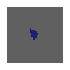

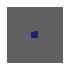

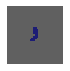

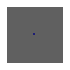

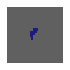

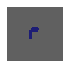

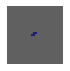

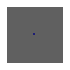

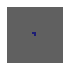

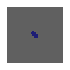

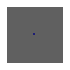

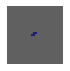

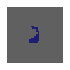

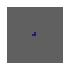

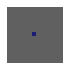

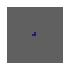

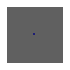

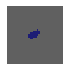

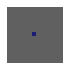

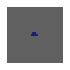

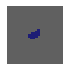

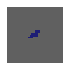

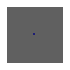

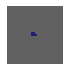

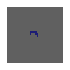

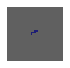

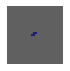

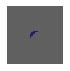

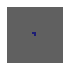

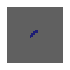

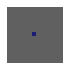

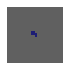

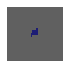

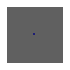

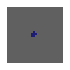

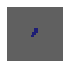

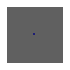

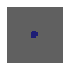

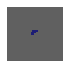

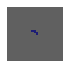

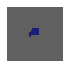

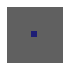

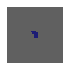

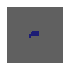

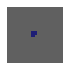

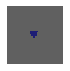

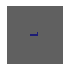

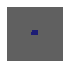

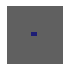

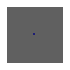

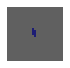

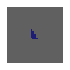

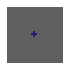

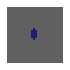

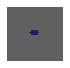

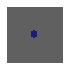

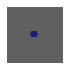

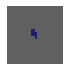

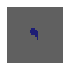

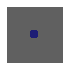

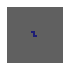

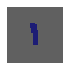

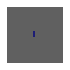

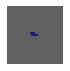

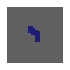

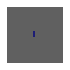

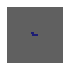

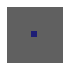

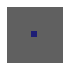

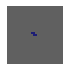

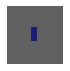

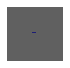

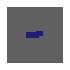

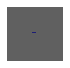

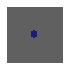

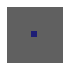

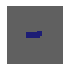

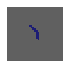

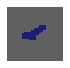

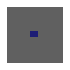

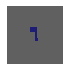

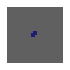

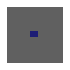

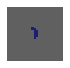

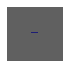

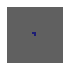

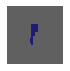

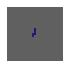

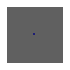

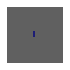

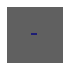

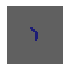

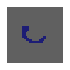

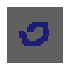

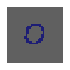

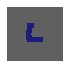

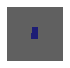

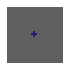

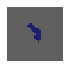

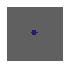

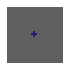

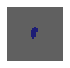

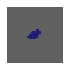

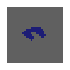

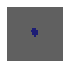

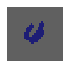

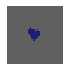

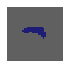

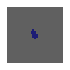

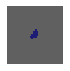

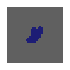

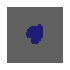

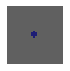

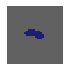

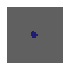

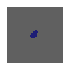

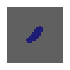

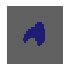

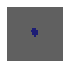

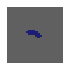

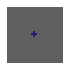

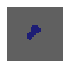

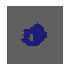

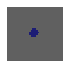

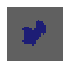

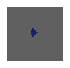

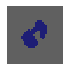

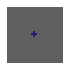

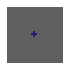

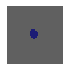

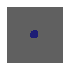

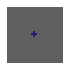

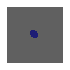

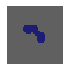

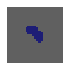

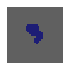

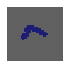

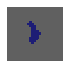

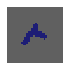

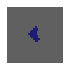

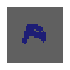

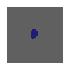

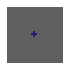

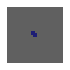

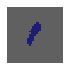

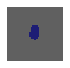

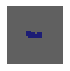

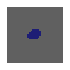

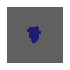

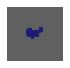

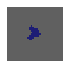

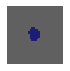

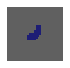

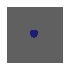

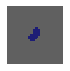

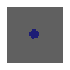

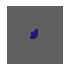

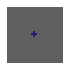

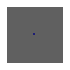

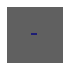

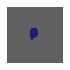

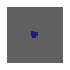

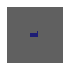

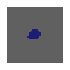

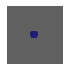

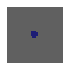

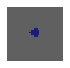

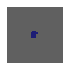

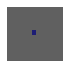

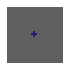

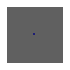

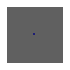

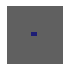

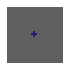

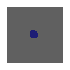

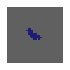

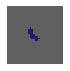

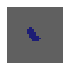

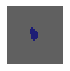

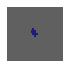

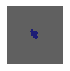

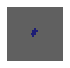

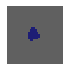

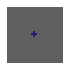

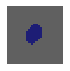

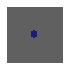

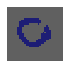

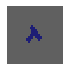

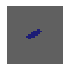

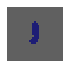

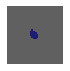

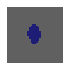

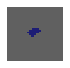

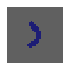

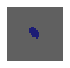

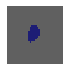

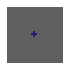

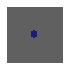

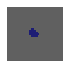

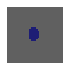

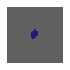

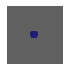

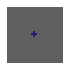

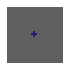

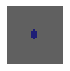

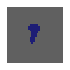

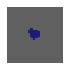

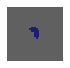

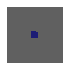

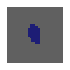

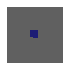

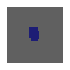

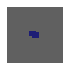

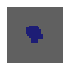

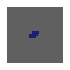

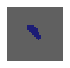

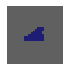

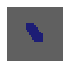

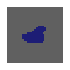

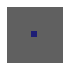

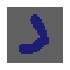

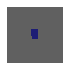

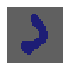

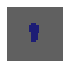

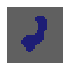

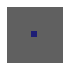

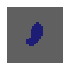

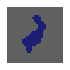

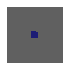

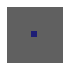

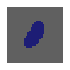

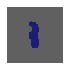

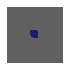

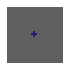

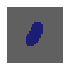

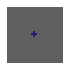

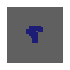

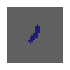

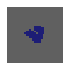

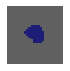

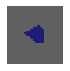

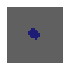

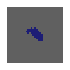

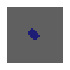

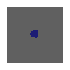

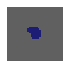

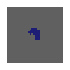

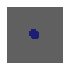

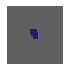

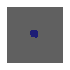

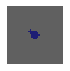

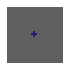

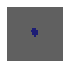

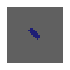

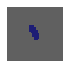

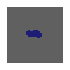

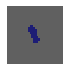

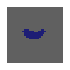

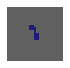

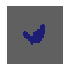

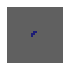

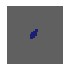

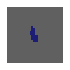

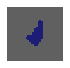

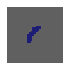

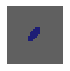

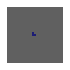

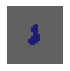

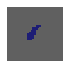

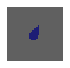

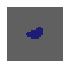

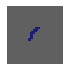

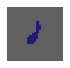

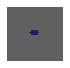

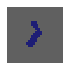

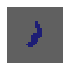

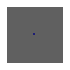

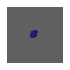

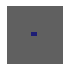

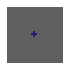

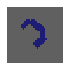

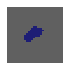

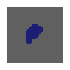

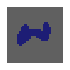

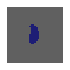

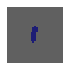

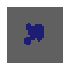

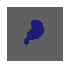

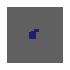

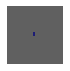

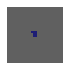

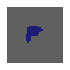

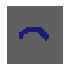

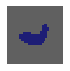

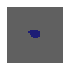

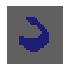

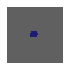

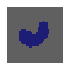

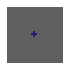

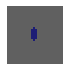

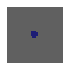

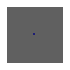

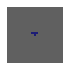

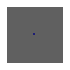

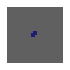

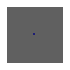

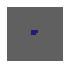

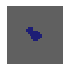

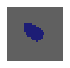

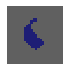

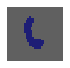

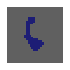

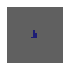

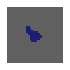

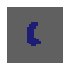

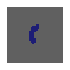

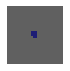

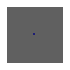

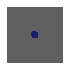

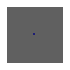

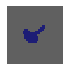

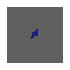

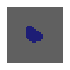

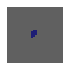

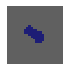

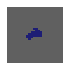

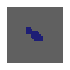

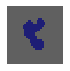

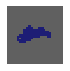

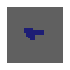

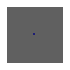

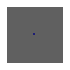

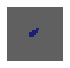

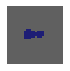

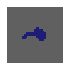

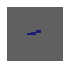

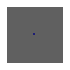

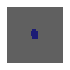

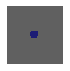

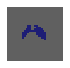

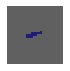

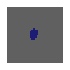

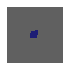

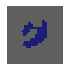

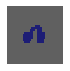

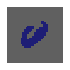

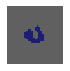

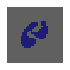

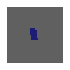

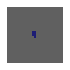

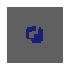

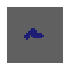

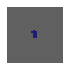

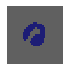

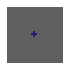

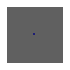

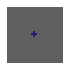

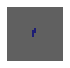

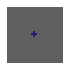

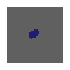

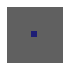

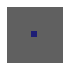

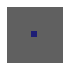

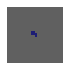

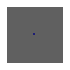

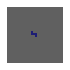

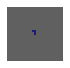

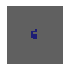

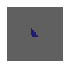

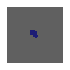

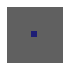

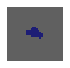

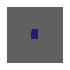

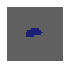

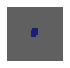

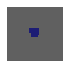

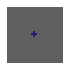

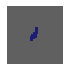

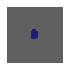

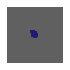

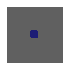

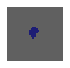

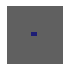

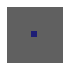

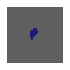

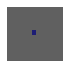

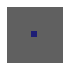

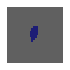

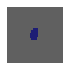

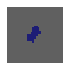

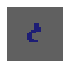

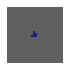

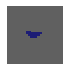

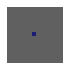

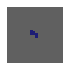

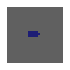

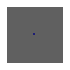

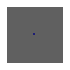

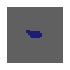

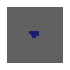

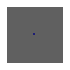

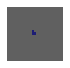

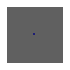

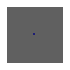

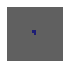

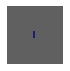

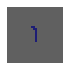

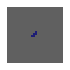

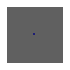

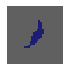

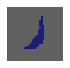

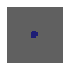

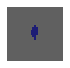

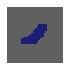

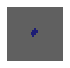

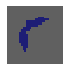

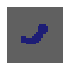

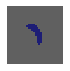

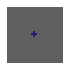

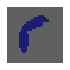

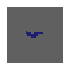

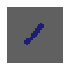

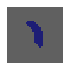

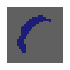

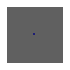

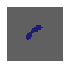

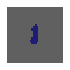

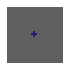

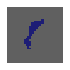

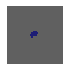

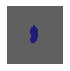

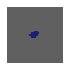

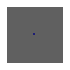

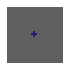

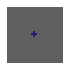

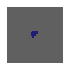

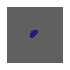

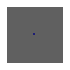

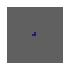

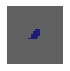

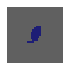

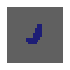

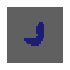

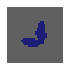

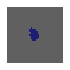

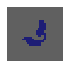

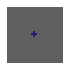

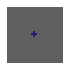

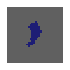

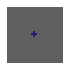

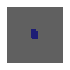

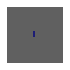

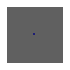

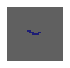

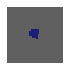

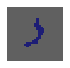

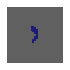

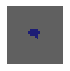

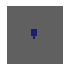

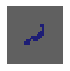

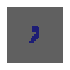

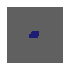

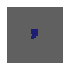

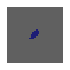

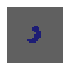

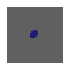

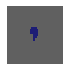

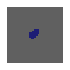

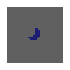

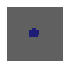

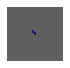

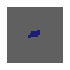

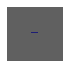

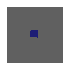

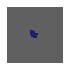

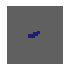

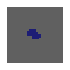

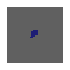

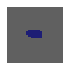

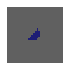

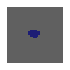

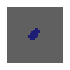

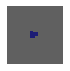

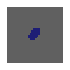

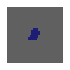

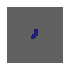

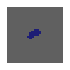

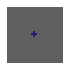

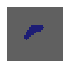

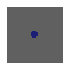

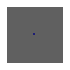

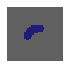

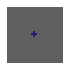

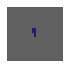

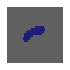

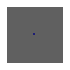

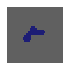

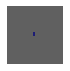

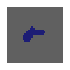

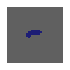

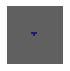

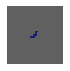

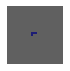

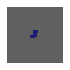

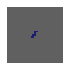

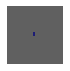

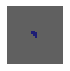

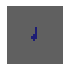

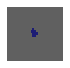

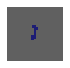

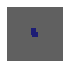

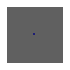

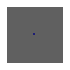

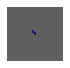

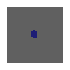

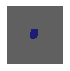

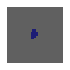

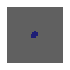

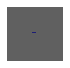

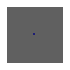

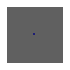

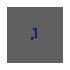

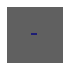

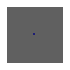

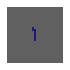

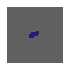

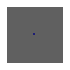

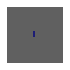

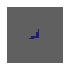

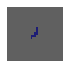

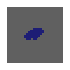

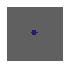

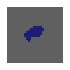

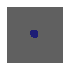

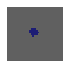

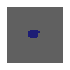

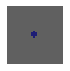

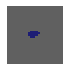

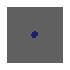

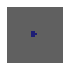

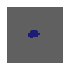

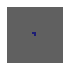

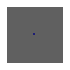

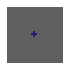

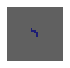

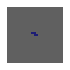

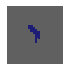

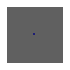

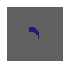

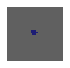

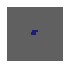

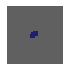

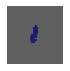

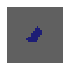

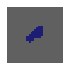

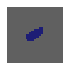

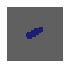

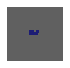

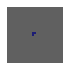

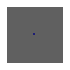

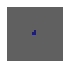

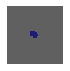

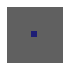

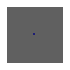

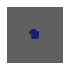

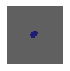

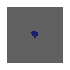

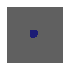

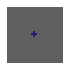

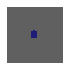

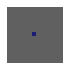

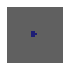

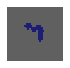

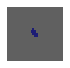

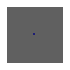

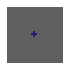

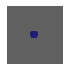

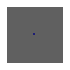

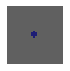

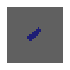

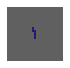

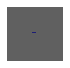

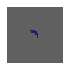

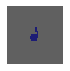

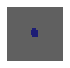

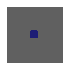

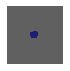

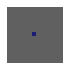

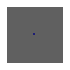

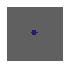

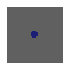

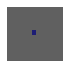

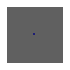

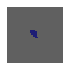

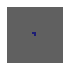

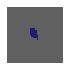

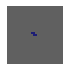

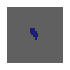

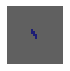

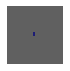

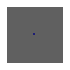

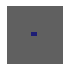

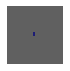

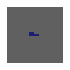

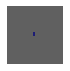

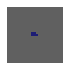

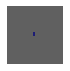

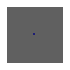

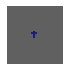

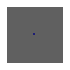

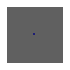

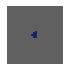

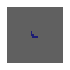

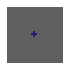

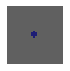

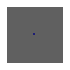

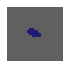

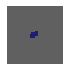

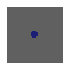

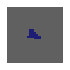

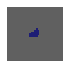

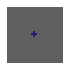

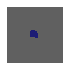

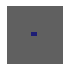

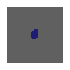

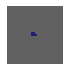

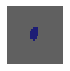

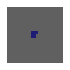

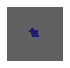

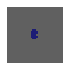

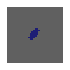

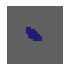

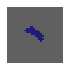

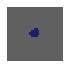

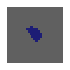

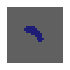

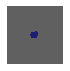

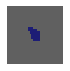

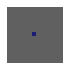

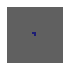

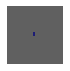

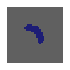

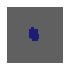

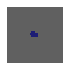

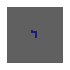

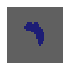

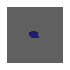

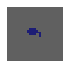

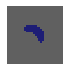

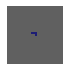

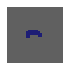

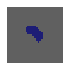

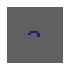

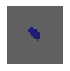

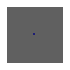

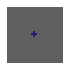

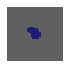

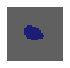

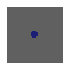

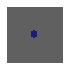

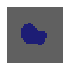

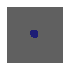

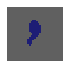

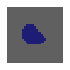

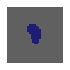

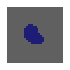

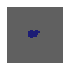

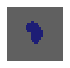

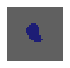

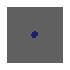

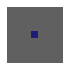

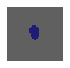

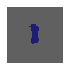

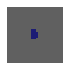

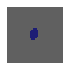

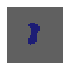

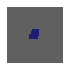

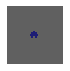

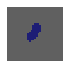

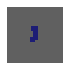

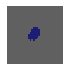

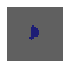

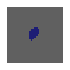

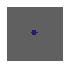

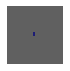

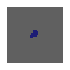

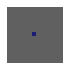

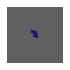

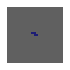

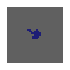

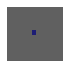

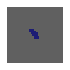

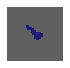

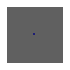

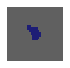

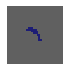

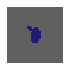

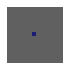

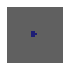

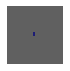

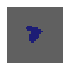

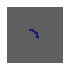

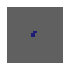

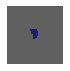

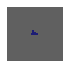

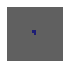

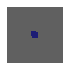

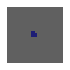

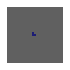

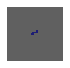

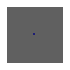

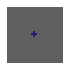

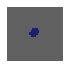

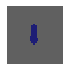

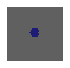

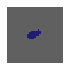

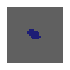

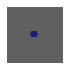

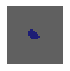

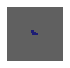

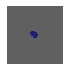

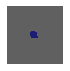

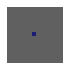

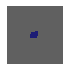

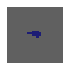

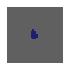

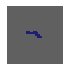

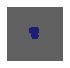

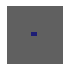

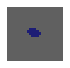

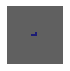

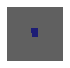

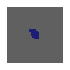

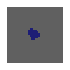

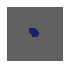

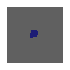

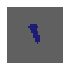

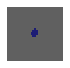

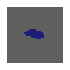

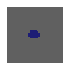

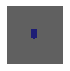

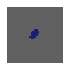

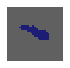

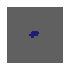

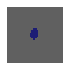

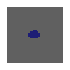

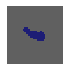

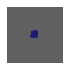

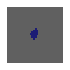

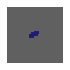

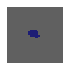

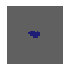

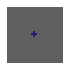

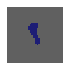

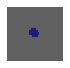

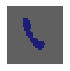

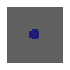

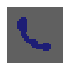

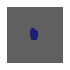

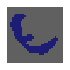

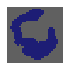

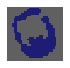

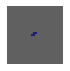

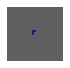

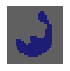

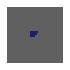

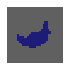

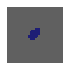

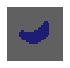

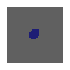

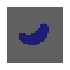

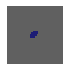

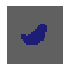

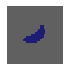

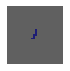

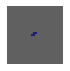

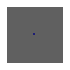

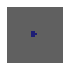

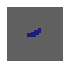

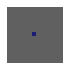

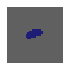

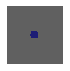

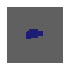

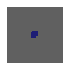

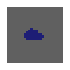

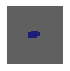

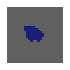

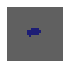

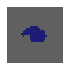

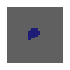

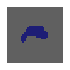

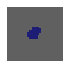

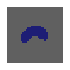

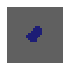

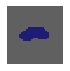

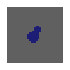

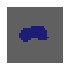

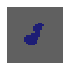

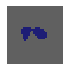

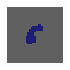

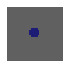

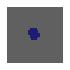

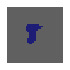

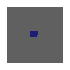

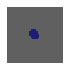

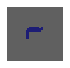

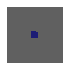

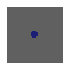

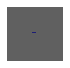

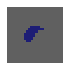

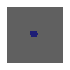

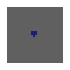

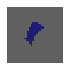

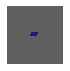

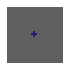

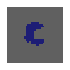

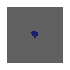

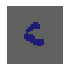

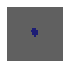

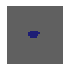

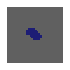

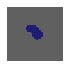

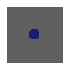

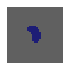

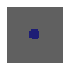

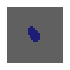

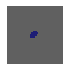

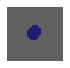

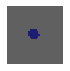

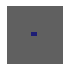

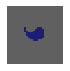

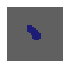

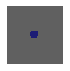

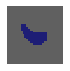

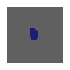

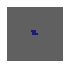

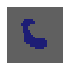

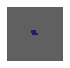

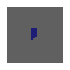

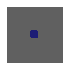

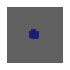

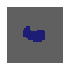

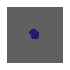

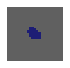

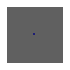

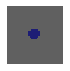

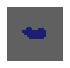

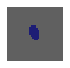

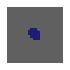

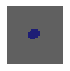

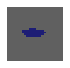

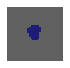

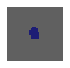

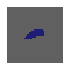

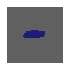

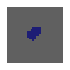

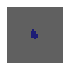

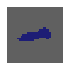

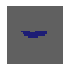

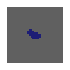

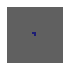

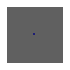

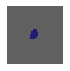

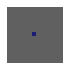

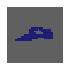

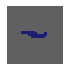

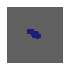

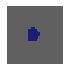

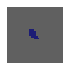

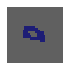

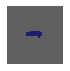

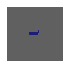

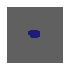

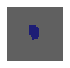

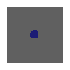

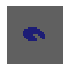

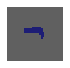

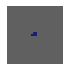

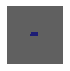

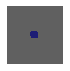

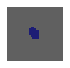

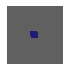

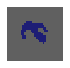

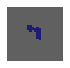

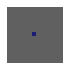

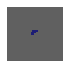

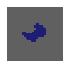

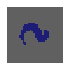

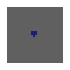

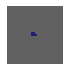

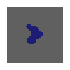

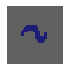

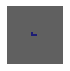

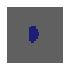

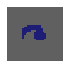

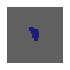

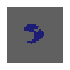

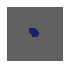

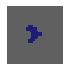

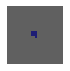

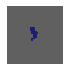

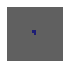

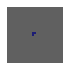

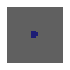

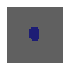

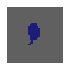

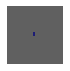

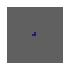

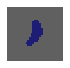

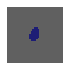

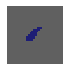

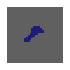

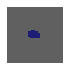

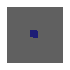

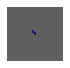

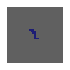

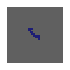

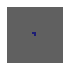

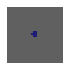

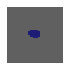

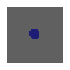

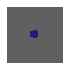

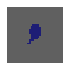

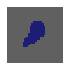

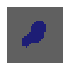

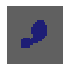

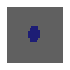

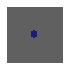

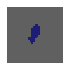

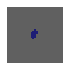

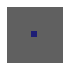

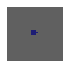

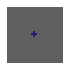

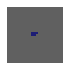

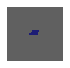

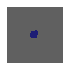

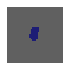

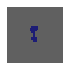

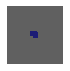

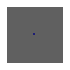

In [12]:
for i,j in enumerate(image_patches):
    C.Util.view(image_patches[i], label_patches[i] )

In [13]:
image_count = len(image_patches)
images_npy = np.zeros((image_count, 32,32,1), dtype=image_patches[0].dtype)
labels_npy = np.zeros((image_count, 32,32,1), dtype=label_patches[0].dtype)

for i,img in enumerate(image_patches):
    
    images_npy[i] = image_patches[i][0:32,0:32,:]
    labels_npy[i] = label_patches[i][0:32,0:32,:]

In [14]:
# normalize images
for z in range(images_npy.shape[0]):
    
    images_npy[z] = (images_npy[z] - images_npy[z].min()) / (images_npy[z].max() - images_npy[z].min())

In [15]:
images_npy.max()

1.0

In [16]:
labels_npy.shape

(1034, 32, 32, 1)

In [17]:
labels_npy.dtype

dtype('int32')

In [18]:
images_npy.dtype

dtype('float64')

In [19]:
images_npy.max()

1.0

In [20]:
labels_npy.max()

1

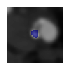

In [21]:
C.Util.view(images_npy[10], labels_npy[10], vmin=0, vmax=1)

In [22]:
#
# now we can store padded_images and padded_labels as .npy files
#
np.save(os.path.join(DATAPATH, 'images_cropped.npy'), images_npy)
np.save(os.path.join(DATAPATH, 'labels_cropped.npy'), labels_npy)